In [1]:
from sklearn.metrics import mean_absolute_error as MSE
from common import *
from models import *

# Reading the data

In [2]:
df = pd.read_csv("../data/input_data/MAIN_DATASET.csv")

price = df['NO2_price'].values.reshape(-1,1)
aload = df['NO2_load_forecasted'].values.reshape(-1,1)
#fload = df['NO2_load_actual'].values.reshape(-1,1)
#fgen = df['NO2_generation_forecast'].values.reshape(-1,1)
agen = df['NO2_generation_actual'].values.reshape(-1,1)
nve = df['NO2_Fyllingsgrad_NVE'].values.reshape(-1,1)

price_days = seperate_column_to_days(price)
aload_days = seperate_column_to_days(aload)
#fload_days = seperate_column_to_days(fload)
#fgen_days = seperate_column_to_days(fgen)
agen_days = seperate_column_to_days(agen)
nve_days = seperate_column_to_days(nve)

# Preprocessing the data

In [3]:
lookbehind = 14
input_width = lookbehind*24
horizon = 24
no_hours = input_width + horizon
hour_in_days = int(no_hours / 24)

price_dataset = []
aload_dataset = []
#fload_dataset = []
#fgen_dataset = []
agen_dataset = []
nve_dataset = []
for i in range(len(price_days) - hour_in_days+1):
    price_dataset.append(np.concatenate((price_days[i:i+hour_in_days])))
    aload_dataset.append(np.concatenate((aload_days[i:i+hour_in_days])))
    #fload_dataset.append(np.concatenate((fload_days[i:i+hour_in_days])))
    #fgen_dataset.append(np.concatenate((fgen_days[i:i+hour_in_days])))
    agen_dataset.append(np.concatenate((agen_days[i:i+hour_in_days])))
    nve_dataset.append(np.concatenate((nve_days[i:i+hour_in_days])))

price_dataset = np.array(price_dataset)
aload_dataset = np.array(aload_dataset)
#fload_dataset = np.array(fload_dataset)
#fgen_dataset = np.array(fgen_dataset)
agen_dataset = np.array(agen_dataset)
nve_dataset = np.array(nve_dataset)

scaler = MinMaxScaler()
price_dataset = scaler.fit_transform(price_dataset[:,:,0])
price_dataset = price_dataset[..., np.newaxis].astype(np.float32)

aload_dataset = scaler.fit_transform(aload_dataset[:,:,0])
aload_dataset = aload_dataset[..., np.newaxis].astype(np.float32)

#fload_dataset = scaler.fit_transform(fload_dataset[:,:,0])
#fload_dataset = fload_dataset[..., np.newaxis].astype(np.float32)

#fgen_dataset = scaler.fit_transform(fgen_dataset[:,:,0])
#fgen_dataset = fgen_dataset[..., np.newaxis].astype(np.float32)

agen_dataset = scaler.fit_transform(agen_dataset[:,:,0])
agen_dataset = agen_dataset[..., np.newaxis].astype(np.float32)

nve_dataset = scaler.fit_transform(nve_dataset[:,:,0])
nve_dataset = nve_dataset[..., np.newaxis].astype(np.float32)

dataset = np.concatenate((price_dataset, aload_dataset, agen_dataset, nve_dataset), axis=2)
n,m,k = dataset.shape

# Splitting the data

In [4]:
train = int(0.7*n)
valid = int(0.9*n)
X_train, y_train = dataset[:train, :input_width, :-1], dataset[:train, -horizon:, :1]
X_valid, y_valid = dataset[train:valid, :input_width, :-1], dataset[train:valid, -horizon:, :1]
X_test, y_test = dataset[valid:, :input_width, :-1], dataset[valid:, -horizon:, :1]

Y = np.empty((n, input_width, horizon))
for step_ahead in range(1, horizon + 1):
    Y[:,:, step_ahead - 1] = dataset[:,step_ahead:step_ahead + input_width, 0]

Y_train = Y[:train]
Y_valid = Y[train:valid]
Y_test = Y[valid:]

print(f"{X_train.shape=}")
print(f"{X_valid.shape=}")
print(f"{X_test.shape=}")

print(f"{Y_train.shape=}")
print(f"{Y_valid.shape=}")
print(f"{Y_test.shape=}")

X_train.shape=(1496, 336, 3)
X_valid.shape=(428, 336, 3)
X_test.shape=(214, 336, 3)
Y_train.shape=(1496, 336, 24)
Y_valid.shape=(428, 336, 24)
Y_test.shape=(214, 336, 24)


# Setting up the sequence to sequence multivariate models

In [5]:
model = keras.models.Sequential([
    #keras.layers.Conv1D(filters=32, kernel_size=3, strides=2, padding="valid", input_shape=[None, k-1]),
    keras.layers.Dense(32, activation='relu', input_shape=[None, k-1]),
    keras.layers.Dense(32, activation='relu'),
    #dnn1 = Dense(hidden_neurons/2, activation='relu', name='dnn1')(dnn)
    keras.layers.GRU(64, activation='tanh', return_sequences=True),
    keras.layers.GRU(64, activation='tanh', return_sequences=True),
    #keras.layers.GRU(32, return_sequences=True),
    #keras.layers.GRU(64, return_sequences=True),
    keras.layers.Dense(horizon, activation='leaky_relu')
])

2021-12-14 19:49:44.061306: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-12-14 19:49:44.069750: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2021-12-14 19:49:44.069768: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2021-12-14 19:49:44.070314: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (o

In [6]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
epochs = 10
model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])

In [7]:
history = model.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid))

Epoch 1/10
47/47 [==============================] - 15s 272ms/step - loss: 0.0076 - last_time_step_mse: 0.0656 - val_loss: 0.0032 - val_last_time_step_mse: 0.0443
Epoch 2/10
47/47 [==============================] - 12s 260ms/step - loss: 0.0026 - last_time_step_mse: 0.0390 - val_loss: 0.0039 - val_last_time_step_mse: 0.0497
Epoch 3/10
47/47 [==============================] - 12s 261ms/step - loss: 0.0019 - last_time_step_mse: 0.0301 - val_loss: 0.0048 - val_last_time_step_mse: 0.0567
Epoch 4/10
47/47 [==============================] - 12s 260ms/step - loss: 0.0013 - last_time_step_mse: 0.0263 - val_loss: 0.0037 - val_last_time_step_mse: 0.0497
Epoch 5/10
47/47 [==============================] - 12s 262ms/step - loss: 0.0010 - last_time_step_mse: 0.0224 - val_loss: 0.0037 - val_last_time_step_mse: 0.0499
Epoch 6/10
47/47 [==============================] - 12s 257ms/step - loss: 8.9314e-04 - last_time_step_mse: 0.0201 - val_loss: 0.0029 - val_last_time_step_mse: 0.0427
Epoch 7/10
47/47 [

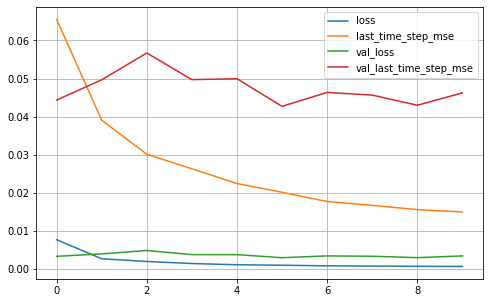

In [8]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
#plt.gca().set_ylim(-0,0.06)
plt.show()

In [9]:
Y_pred = model.predict(X_test)

In [10]:
print(f"{MSE(Y_test[:,-1], Y_pred[:,-1])=}")

MSE(Y_test[:,-1], Y_pred[:,-1])=0.063832616603479


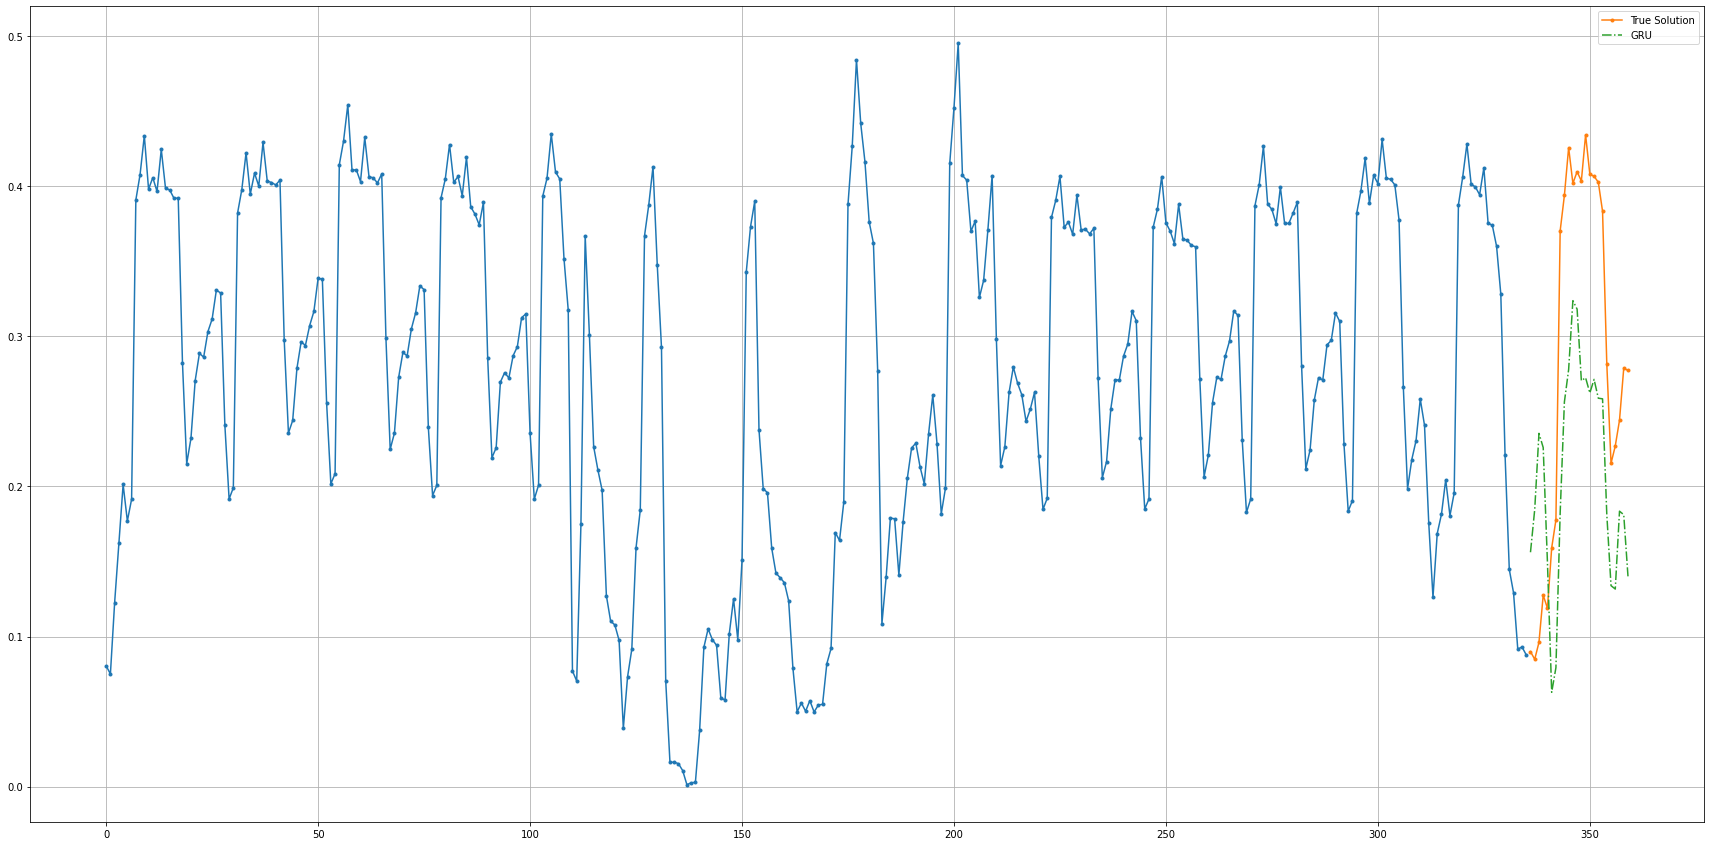

In [11]:
x = np.arange(no_hours)
plt.figure(figsize=(30,15))
plt.plot(x[:no_hours-horizon], X_test[36,:,0].flatten(), '.-')
plt.plot(x[-horizon:], Y_test[36,-1].flatten(), '.-', label="True Solution")
plt.plot(x[-horizon:], Y_pred[36,-1].flatten(), '-.', label="GRU")
plt.legend()
plt.grid()
plt.show()